## Figures

- Figure 1 D,E
- Figure S1 A,B

## Required files

`model_dir = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/output/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'`
- {model_dir}/calibrated_seq_model.pkl
- {model_dir}/history.csv
- Files in `ChIP-nexus.dataspec.yml`


## Output

`figures = f'{ddir}/figures/model-evaluation/chipnexus-bpnet/{exp}'`
- Figure 1D, Figure S1A
  - `{figures}/profiles/top-sum-max-count-{idx}-{interval_str}.pdf`
- Figure 1E
  - `{figures}/profile-metrics/auprc.pdf`
- Figure S1B
  - `{figures}/scatter/all.pdf`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from basepair.imports import *
from basepair.extractors import bw_extract
from basepair.datasets import StrandedProfile
from basepair.preproc import AppendCounts
from basepair.config import valid_chr, test_chr
from basepair.plot.evaluate import regression_eval
from basepair.plot.utils import plt9_tilt_xlab
from basepair.cli.evaluate import eval_profile
from basepair.exp.paper.config import *
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

paper_config() # Use matplotlib paper config

Using TensorFlow backend.


In [2]:
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
gpu = ''  # Don't use GPU when ''

In [3]:
from basepair.config import get_data_dir, get_repo_root
rdir = get_repo_root()

# Common paths
model_dir = models_dir / exp
figures = f"{ddir}/figures/model-evaluation/chipnexus-bpnet/{exp}"

# Parameters
dataspec_file = rdir / "src/bpnet-pipeline/ChIP-nexus.dataspec.yml"
history_file = model_dir / "history.csv"
seq_width = 1000
num_workers = 10

In [4]:
model_dir

PosixPath('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/output/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE')

## Get predictions

In [5]:
create_tf_session(gpu)
bpnet = SeqModel.load(model_dir / 'calibrated_seqmodel.pkl')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2020-10-24 16:55:33,779 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2020-10-24 16:55:46,142 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
ds = DataSpec.load(dataspec_file)
tasks = list(ds.task_specs)

In [7]:
profile_bias_pool_size = [1,50]  # Note: this is specific to the model

In [8]:
# Uncomment to re-generate predictions.
# !mv {model_dir}/preds.test.pkl {model_dir}/preds.test.pkl.bak

In [9]:
# Get the predictions
if not os.path.exists(model_dir / "preds.test.pkl"):
    from basepair.seqmodel import SeqModel
    dl_test = StrandedProfile(ds, 
                              incl_chromosomes=test_chr, 
                              peak_width=seq_width,
                              shuffle=False,
                              target_transformer=AppendCounts(),
                              profile_bias_pool_size=profile_bias_pool_size)

    test = dl_test.load_all(num_workers=num_workers)
    y_true = test["targets"]
    y_pred = bpnet.predict(test['inputs'])
    write_pkl((test, y_pred), model_dir / "preds.test.pkl")

# Load predictions
test, y_pred = read_pkl(model_dir / "preds.test.pkl")
y_true = test['targets']

In [10]:
# Load the training data and compute the average profile
dl_train = StrandedProfile(ds, 
                           excl_chromosomes=test_chr + valid_chr, 
                           peak_width=seq_width,
                           shuffle=False)
train_data = dl_train.load_all(num_workers=num_workers)
avg_profile = {k.split("/")[1]: v.mean(axis=0) for k,v in train_data['targets'].items()}

100%|██████████| 2935/2935 [01:05<00:00, 44.65it/s] 


## Profile plots (predicted vs observed)

- for each set of TF peaks (all non-overlapping) in the test set (chr1, chr8, chr9), choose two with most counts

In [11]:
from basepair.plot.profiles import plot_profiles
from basepair import samplers
from kipoi.data_utils import get_dataset_item
from kipoi.metadata import GenomicRanges
import pybedtools
from basepair.utils import flatten_list
from basepair.plot.tracks import plot_tracks, filter_tracks
from basepair.preproc import dfint_no_intersection
from pybedtools import BedTool

In [12]:
# Figure out valid indices (non-overlapping)
df_ranges = pd.DataFrame(test['metadata']['range'])[['chr', 'start','end']]
df_ranges_tasks = {t: df_ranges[test['metadata']['interval_from_task'] == t] for t in bpnet.tasks}
all_intervals = list(BedTool.from_dataframe(df_ranges))

o = dict()
for i,t in enumerate(bpnet.tasks):
    dft = df_ranges.iloc[test['metadata']['interval_from_task'] == t]
    if i == 0:
        o[t] = dft
    else:
        df_existing = pd.concat(list(o.values()), axis=0)
        o[t] = dft[dfint_no_intersection(dft, df_existing)]
valid_idx = pd.concat(list(o.values()), axis=0).index

valid_idx_bool = pd.Series(np.arange(len(df_ranges))).isin(valid_idx)

print("Fraction of non-overlapping peaks:", valid_idx_bool.mean())

Fraction of non-overlapping peaks: 0.5853139539077433


In [13]:
from genomelake.extractors import FastaExtractor
from basepair.preproc import resize_interval

In [14]:
input_seqlen = 1000 - bpnet.body.get_len_change()  - bpnet.heads[0].net.get_len_change()

In [15]:
# Check how much of the total counts is allocated at a single position
yt = sum([y_true[f'profile/{task}']
          for task in tasks])

(yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2)).max()

max_frac = (yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2))

max_pos = (yt ).max(axis=(-1, -2))
total_counts = (yt ).sum(axis=(-1, -2))
n_zeros = np.sum(yt == 0, axis=(-1, -2))

In [16]:
from basepair.exp.paper.config import tf_colors

# Generate the right colors
colors = []
for task in bpnet.tasks:
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    
def to_neg(track):
    """Use the negative sign for reads on the reverse strand
    """
    track = track.copy()
    track[:, 1] = - track[:, 1]
    return track    

In [17]:
from basepair.samplers import top_sum_count, top_max_count

In [18]:
def top_max_count(arr, end=10, start=0, keep=None):
    """
    Return indices where arr has the highest max(pos) + max(neg)

    Args:
      arr: can be an array or a list of arrays
      start: Where to start returning the values
      end: where to stop
    """
    if keep is None:
        keep = np.arange(len(arr))
    assert end > start
    # Top maxcount indicies
    return pd.Series(arr.max(1).sum(1))[keep].sort_values(ascending=False).index[start:end]

In [19]:
# Get the idx to test
idx_set = set()
for task in bpnet.tasks:
    keep = ((test['metadata']['interval_from_task'] == task) & valid_idx_bool &
            valid_idx_bool & ~((max_pos > 400) & (n_zeros > 1000))
            )
    idx_set.update(top_max_count(y_true[f'profile/{task}'],10,keep=keep))
    idx_set.update(top_sum_count(y_true[f'profile/{task}'],10,keep=keep))

In [20]:
plot_individual_profiles = False
if plot_individual_profiles:
    trim_edge = 300
    xlim = [trim_edge, 1000 - trim_edge]
    fig_width=get_figsize(0.5)[0]
    rotate_y=90
    fig_height_per_track=0.5
    tasks = bpnet.tasks

    for idx in idx_set:
        # get the interval for that idx
        r = get_dataset_item(test['metadata']['range'], idx)
        interval = pybedtools.create_interval_from_list([r['chr'], int(r['start']), int(r['end'])])
        interval_str = f"{interval.chrom}:{interval.start + trim_edge}-{interval.end - trim_edge}"

        # make prediction

        fe = FastaExtractor(ds.fasta_file)
        seq = fe([resize_interval(interval, input_seqlen, ignore_strand=True)])
        x = bpnet.neutral_bias_inputs(1000, 1000)
        x['seq'] = seq
        pred = bpnet.predict(x)


        # compile the list of tracks to plot
        viz_dict =flatten_list([[
            # Observed
            (f"{task}\nObs", to_neg(y_true[f'profile/{task}'][idx])),
            # Predicted
            (f"\nPred", to_neg(pred[f'{task}/profile'][0] * np.exp(pred[f'{task}/counts'][0]))),
        ] for task_idx, task in enumerate(tasks)])

        sl = slice(*xlim)
        # Get ylim
        ylim = []
        for task in tasks:
            m = y_true[f'profile/{task}'][idx][sl].max()
            ylim.append((-m,m))
            m = (pred[f'{task}/profile'][0] * np.exp(pred[f'{task}/counts'][0])).max()
            ylim.append((-m,m))

        fig = plot_tracks(filter_tracks(viz_dict, xlim),
                          title=interval_str,
                          fig_height_per_track=fig_height_per_track,
                          rotate_y=rotate_y,
                          use_spine_subset=True,
                          color=colors,
                          fig_width=fig_width,
                          ylim=ylim,
                          legend=False)
        fig.align_ylabels()
        sns.despine(top=True, right=True, bottom=True)
        os.makedirs(f"{figures}/profiles", exist_ok=True)
        fig.savefig(f"{figures}/profiles/top-sum-max-count-{idx}-{interval_str}.pdf")
        # fig.savefig(f"{figures}/profiles/top-sum-max-count-{idx}-{interval_str}.png")

### Replicate performance

In [22]:
rep_indices = [f'N{x:02d}' for x in np.arange(1, 21)]
reps = pd.read_csv("https://docs.google.com/spreadsheets/d/1PvHGy0P9_Yq0tZFw807bjadxaZHAYECE4RytlI9rdeQ/export?gid=0&format=csv")
reps = reps[reps.Mnemonic.isin(rep_indices)]

In [23]:
reps.head()

,Mnemonic,FTP Name,thenexus Name,Sample ID,Comments,Reference,Data Type,TF Name,Rep Number,Control Reps,QC report,Unique deduped reads,Held-out test,"#Rep-IDRpeaks (N1, N2, ..)",#IDR-optimal peaks (Np),Md5-hash-FASTQ,Md5-hash-IDRoptimal,Md5-bigwigs,idr_frip_qc/ppr/FRiP,idr_reproducibility_qc/rescue_ratio,Oak path bw neg
16,N01,mesc_oct4_nexus_1.fas...,NaN,NaN,NaN,mm10,chipnexus,oct4,1.0,NaN,http://mitra.stanford...,31M,False,8772.0,25849.0,459a81cf3075ea87d40b7...,NaN,NaN,NaN,NaN,NaN
17,N02,mesc_oct4_nexus_2.fas...,NaN,NaN,NaN,mm10,chipnexus,oct4,2.0,NaN,http://mitra.stanford...,50M,True,10548.0,25849.0,536a72cc5c79707e22073...,NaN,NaN,NaN,NaN,NaN
18,N03,mesc_oct4_nexus_3.fas...,NaN,NaN,NaN,mm10,chipnexus,oct4,3.0,NaN,http://mitra.stanford...,48M,True,5996.0,25849.0,9a3abcdf2be00d2e6a73e...,NaN,NaN,NaN,NaN,NaN
19,N04,mesc_oct4_nexus_4.fas...,NaN,NaN,NaN,mm10,chipnexus,oct4,4.0,NaN,http://mitra.stanford...,51M,False,7572.0,25849.0,ad16824c3e3eafe0475f4...,NaN,NaN,NaN,NaN,NaN
20,N05,mesc_oct4_nexus_5.fas...,NaN,NaN,NaN,mm10,chipnexus,oct4,5.0,NaN,http://mitra.stanford...,30M,True,8226.0,25849.0,f8cafa07687a9767146f0...,NaN,NaN,NaN,NaN,NaN


In [24]:
from basepair.cli.schemas import DataSpec, TaskSpec

In [25]:
# TODO - move data to OAK

In [27]:
'asd'.lower()

'asd'

In [36]:
def get_bigwig(row, strand):
    rep_n = int(row['Rep Number'])
    task = row['TF Name'].capitalize()
    rep_name = row['FTP Name'].split(".")[0]
    pipeline_dir = '/oak/stanford/groups/akundaje/avsec/software/chip-nexus-pipeline/cromwell-executions/chip_nexus'
    path = f"{pipeline_dir}/{task}/call-count_signal_track/shard-{rep_n -1}/execution/{rep_name}.trim.merged.nodup.{strand}.bigwig"
    if not os.path.exists(path):
        raise ValueError(f'Path {path} does not exist.')
    return path

def get_taskspec(rows):
    task = rows.iloc[0]['TF Name'].capitalize()
    pos_counts=[get_bigwig(rows.iloc[i], 'positive') for i in range(len(rows))]
    neg_counts=[get_bigwig(rows.iloc[i], 'negative') for i in range(len(rows))]
    return TaskSpec(task=task, pos_counts=pos_counts, neg_counts=neg_counts)

In [37]:
dataspec_train = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == False)])
                                                 for task in tasks},
                  fasta_file="")

In [38]:
dataspec_train.touch_all_files()

In [39]:
dataspec_test = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == True)])
                                                 for task in tasks},
                  fasta_file="")

In [40]:
dataspec_test.touch_all_files()

## Compute the same stats for the technical replicates

- always have two technical replicates for each factor

In [41]:
train = dataspec_train.load_counts(all_intervals, progbar=True)
test = dataspec_test.load_counts(all_intervals, progbar=True)

100%|██████████| 27727/27727 [00:05<00:00, 5415.07it/s]


In [42]:
bias_data = ds.load_bias_counts(all_intervals, progbar=True)
# Use 'input' for each task
bias_data = {task: bias_data['input'] for task in tasks}

### Evaluate

In [43]:
from basepair.cli.evaluate import bin_counts_summary
from basepair.losses import multinomial_nll as k_multinomial_nll
from basepair.exp.paper.config import peak_pred_metric
from basepair.metrics import *
import keras.backend as K
import tensorflow as tf
from basepair.stats import symmetric_kl
import matplotlib.pyplot as plt
from basepair.preproc import moving_average
import random


def normalize(x):
    p = x / np.maximum(np.sum(x, axis=-1, keepdims=True), 1e-8)
    p += 1 / (x.shape[-1]*10)  # Should be 
    p = p / np.sum(p, axis=-1, keepdims=True)
    return p

# Override the binsizes for peak_pred_metric
def multinomial_nll(y_true, y_pred):
    from scipy.stats import multinomial
    # subset = y_true.sum(axis=-1) > 0
    subset = slice(None)
    return -multinomial.logpmf(x=y_true[subset],
                               n=y_true[subset].sum(axis=-1), 
                               p=normalize(y_pred[subset]))


class StrandedMetric:
    def __init__(self, metric):
        self.metric = metric
        
    def __call__(self, y_true, y_pred):
        return (self.metric(y_true[:, :, 0], y_pred[:, :, 0]) + 
                self.metric(y_true[:, :, 1], y_pred[:, :, 1])) / 2

class BinnedMetric:
    def __init__(self, metric, binsizes):
        self.metric = metric
        self.binsizes = binsizes

    def __call__(self, y_true, y_pred):
        return {f"binsize={binsize}": self.metric(
            bin_counts_summary(y_true, binsize=binsize, fn=np.sum),
            bin_counts_summary(y_pred, binsize=binsize, fn=np.sum))
                for binsize in self.binsizes}


class MergeBinnedMetrics:
    def __init__(self, metrics):
        self.metrics = metrics
        
    def __call__(self, y_true, y_pred):
        metric_outputs = [m(y_true, y_pred) for m in self.metrics]
        return {k: {k2: v2 for output in metric_outputs for k2, v2 in output[k].items()}
                for k in metric_outputs[0]}


class MetricDict:    
    def __init__(self, metrics, prefix=''):
        self.metrics = metrics
        self.prefix = prefix
        
    def __call__(self, y_true, y_pred):
        return {self.prefix + metric_name: metric(y_true, y_pred)
                for metric_name, metric in self.metrics.items()}


class SmoothedMetric:
    def __init__(self, metric, smooth_n=None):
        self.metric = metric
        self.smooth_n = smooth_n
    
    def __call__(self, y_true, y_pred):
        if self.smooth_n is not None:
            y_pred = moving_average2(y_pred, n=self.smooth_n, axis=1)
        return self.metric(y_true, y_pred)


class AvgMetric:
    def __init__(self, metric):
        self.metric = metric
    
    def __call__(self, y_true, y_pred):
        return np.nanmean(self.metric(y_true, y_pred))

In [44]:
# Setup the evaluation metric
from basepair.exp.paper.config import peak_pred_metric
from basepair.metrics import *

# Override the binsizes for peak_pred_metric
binsizes = [1, 2, 5, 10, 20]
peak_pred_metric.binsizes = binsizes

# metric = BPNetMetricSingleProfile(
#     count_metric=pearson_spearman,
#     profile_metric=peak_pred_metric
# )


def entropy_axis(y_true, y_pred, axis=1, base=None):
    import scipy
    # Bring forwarard the desired axis.
    y_true = np.moveaxis(y_true, axis, 0)
    y_pred = np.moveaxis(y_pred, axis, 0)
    # scipy.stats.entropy marginalizes along axis=0.
    return scipy.stats.entropy(y_true, y_pred, base=base)


class JensenShannonDivergence:
    def __init__(self, pseudo_counts=1e-4):
        self._pseudo_counts = pseudo_counts
        
    def __call__(self, y_true, y_pred):
        y_true = y_true + self._pseudo_counts
        y_pred = y_pred + self._pseudo_counts
        # Normalize to sum to 1.
        y_true = y_true  / y_true.sum()
        y_pred = y_pred / y_pred.sum()
        return (entropy_axis(y_true, (y_true + y_pred)/2, axis=1, base=2) 
                + entropy_axis(y_pred, (y_true + y_pred)/2, axis=1, base=2)) / 2


metrics = {'Jensen–Shannon_divergence': JensenShannonDivergence(),
           # 'Jensen–Shannon_divergence_pc': SymmetricKL(1e-4),
           }
metrics = {**metrics, 'multinomial_nll': multinomial_nll}
profile_metric = BinnedMetric(MetricDict({k: StrandedMetric(AvgMetric(v)) for k,v in metrics.items()}),
                              binsizes=binsizes)


metric = BPNetMetricSingleProfile(
    count_metric=pearson_spearman,
    profile_metric=MergeBinnedMetrics([peak_pred_metric, profile_metric])
)

In [45]:
from basepair.data import Dataset

In [46]:
def profile_metrics2df(m):
    out = []
    for task,v in m.items():
        for binsize_str, mout in v['profile'].items():
            out.append({"task": task,
                        "binsize": int(binsize_str.split("=")[1]),
                        **mout
                       })
    return pd.DataFrame(out)

def count_metrics2df(m):
    out = []
    for task,v in m.items():
        out.append({"task": task,
                     **v['counts']
                       })
    return pd.DataFrame(out)

In [47]:
def shuffle(x):
    x = x.copy()
    np.random.shuffle(x)
    return x


def moving_average2(x, n=1, axis=0):
    x = np.swapaxes(x, 0, axis)
    x = moving_average(x, n=n)
    return np.swapaxes(x, axis, 0)

In [48]:
task = 'Oct4'

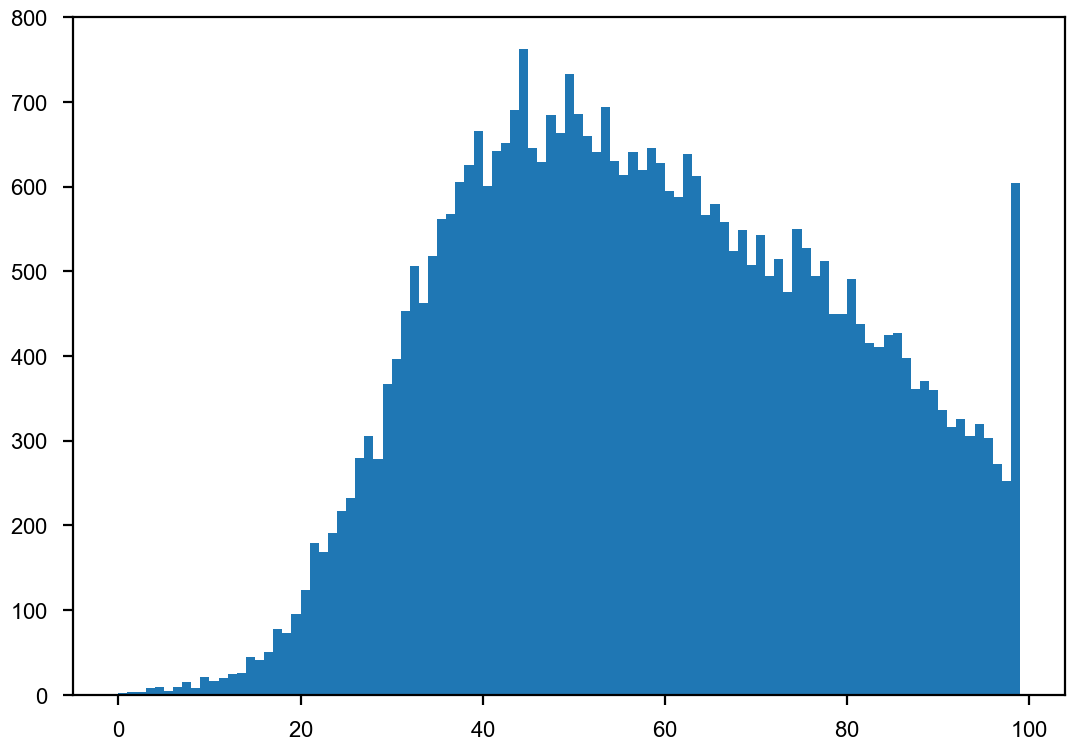

In [49]:
plt.hist(test[task].sum(axis=(1)).ravel(), bins=np.arange(100));

In [ ]:
y_pred_random = np.random.rand(*y_pred[f"{tasks[0]}/profile"].shape)

In [75]:
metrics_rep = {task: metric(test[task], train[task] + 1e-3) for task in tqdm(tasks)}
metrics_rep_smoothed50 = {task: metric(test[task], moving_average2(train[task] + 1e-3, n=50, axis=1)) for task in tqdm(tasks)}
metrics_rep_smoothed3 = {task: metric(test[task], moving_average2(train[task] + 1e-3, n=3, axis=1)) for task in tqdm(tasks)}
metrics_patchcap = {task: metric(test[task], bias_data[task]) for task in tasks}
metrics_model = {task: metric(test[task], y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis])) for task in tasks}
metrics_random = {task: metric(test[task], shuffle(y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis]))) for task in tasks}
metrics_random2 = {task: metric(test[task], y_pred_random) for task in tasks}
# average the training signal
metrics_avg = {task: metric(test[task], 
                            np.repeat(avg_profile[task][np.newaxis], len(test[task]), axis=0)) 
               for task in tasks}
metrics_const = {task: metric(test[task], 
                            np.repeat(np.ones_like(avg_profile[task][np.newaxis]), len(test[task]), axis=0)) 
               for task in tasks}

100%|██████████| 4/4 [02:32<00:00, 38.91s/it]


In [76]:
dfm_profile = profile_metrics2df(metrics_rep).assign(method='Replicates')
dfm_counts = count_metrics2df(metrics_rep).assign(method='Replicates')
# df_auprc_random = dfm_profile.copy()
# df_auprc_random['auprc'] = df_auprc_random['random_auprc']
# df_auprc_random['method'] = 'Random'# + df_auprc_random['method']
df_auprc_random = profile_metrics2df(metrics_random).assign(method='Random')
dfm_profile = pd.concat([dfm_profile, df_auprc_random])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_model).assign(method='BPNet')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_random2).assign(method='Random2')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_avg).assign(method='Average')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_patchcap).assign(method='Patchcap')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_patchcap).assign(method='Const')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_rep_smoothed50).assign(method='ReplicatesSmoothed50')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_rep_smoothed3).assign(method='ReplicatesSmoothed3')])

dfm_counts = pd.concat([dfm_counts,
                        count_metrics2df(metrics_model).assign(method='BPNet'),
                        count_metrics2df(metrics_patchcap).assign(method='Patchcap'),
                       ])

In [77]:
dfm_profile['split'] = 'train->test'
dfm_profile1 = dfm_profile.copy()
dfm_counts['split'] = 'train->test'
dfm_counts1 = dfm_counts.copy()

Swap train and test.

In [78]:
metrics_rep = {task: metric(train[task], test[task]) for task in tqdm(tasks)}
metrics_rep_smoothed50 = {task: metric(train[task], moving_average2(test[task] + 1e-3, n=50, axis=1)) for task in tqdm(tasks)}
metrics_rep_smoothed3 = {task: metric(train[task], moving_average2(test[task] + 1e-3, n=3, axis=1)) for task in tqdm(tasks)}

metrics_patchcap = {task: metric(train[task], bias_data[task]) for task in tasks}
metrics_model = {task: metric(train[task], y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis])) for task in tasks}
metrics_random = {task: metric(train[task], shuffle(y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis]))) for task in tasks}
metrics_random2 = {task: metric(train[task], y_pred_random) for task in tasks}
# average the training signal
metrics_avg = {task: metric(train[task], 
                            np.repeat(avg_profile[task][np.newaxis], len(test[task]), axis=0)) 
               for task in tasks}
metrics_const = {task: metric(train[task], 
                            np.repeat(np.ones_like(avg_profile[task][np.newaxis]), len(test[task]), axis=0)) 
               for task in tasks}

100%|██████████| 4/4 [02:22<00:00, 35.63s/it]


In [79]:
dfm_profile = profile_metrics2df(metrics_rep).assign(method='Replicates')
dfm_counts = count_metrics2df(metrics_rep).assign(method='Replicates')
# df_auprc_random = dfm_profile.copy()
# df_auprc_random['auprc'] = df_auprc_random['random_auprc']
# df_auprc_random['method'] = 'Random'# + df_auprc_random['method']
df_auprc_random = profile_metrics2df(metrics_random).assign(method='Random')
dfm_profile = pd.concat([dfm_profile, df_auprc_random])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_model).assign(method='BPNet')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_random2).assign(method='Random2')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_avg).assign(method='Average')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_patchcap).assign(method='Patchcap')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_const).assign(method='Const')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_rep_smoothed50).assign(method='ReplicatesSmoothed50')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_rep_smoothed3).assign(method='ReplicatesSmoothed3')])


dfm_counts = pd.concat([dfm_counts,
                        count_metrics2df(metrics_model).assign(method='BPNet'),
                        count_metrics2df(metrics_patchcap).assign(method='Patchcap'),
                       ])

In [80]:
dfm_profile['split'] = 'test->train'
dfm_profile2 = dfm_profile.copy()
dfm_counts['split'] = 'test->train'
dfm_counts2 = dfm_counts.copy()

In [81]:
df_auprc_tidy = pd.concat([dfm_profile1, dfm_profile2])

In [82]:
df_counts_tidy = pd.concat([dfm_counts1, dfm_counts2])

In [83]:
# Substract Const to all the other methods.
# We are using index alignment here to make sure the subtractions of task,split,binsize will be aligne.d
df_auprc_tidy_normalized = (df_auprc_tidy.set_index(['task', 'split', 'binsize', 'method']) 
                            - df_auprc_tidy[df_auprc_tidy.method == 'Random'].drop(columns='method').set_index(['task', 'split', 'binsize'])).reset_index()
df_auprc_tidy_normalized

,task,split,binsize,method,Jensen–Shannon_divergence,auprc,frac_ambigous,imbalance,multinomial_nll,n_positives,random_auprc
0,Klf4,test->train,1,Replicates,-0.0605,0.1722,0.0,0.0,74.5503,0,0.0002
1,Klf4,test->train,1,Random,0.0000,0.0000,0.0,0.0,0.0000,0,0.0000
2,Klf4,test->train,1,BPNet,-0.1130,0.0869,0.0,0.0,-25.5753,0,0.0002
...,...,...,...,...,...,...,...,...,...,...,...
357,Sox2,train->test,20,Const,0.2760,-0.3527,0.0,0.0,60.5926,0,-0.0054
358,Sox2,train->test,20,ReplicatesSmoothed50,-0.0202,0.3811,0.0,0.0,-1.1948,0,0.0031
359,Sox2,train->test,20,ReplicatesSmoothed3,0.0764,0.3461,0.0,0.0,15.6818,0,-0.0076


### Plot

In [84]:
from plotnine import *
import plotnine

print('Plotnine version:', plotnine.__version__)
paper_config()

Plotnine version: 0.5.1


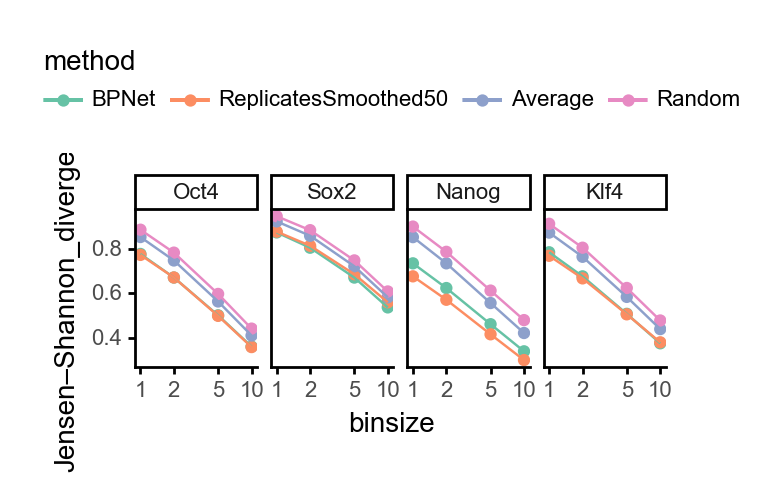

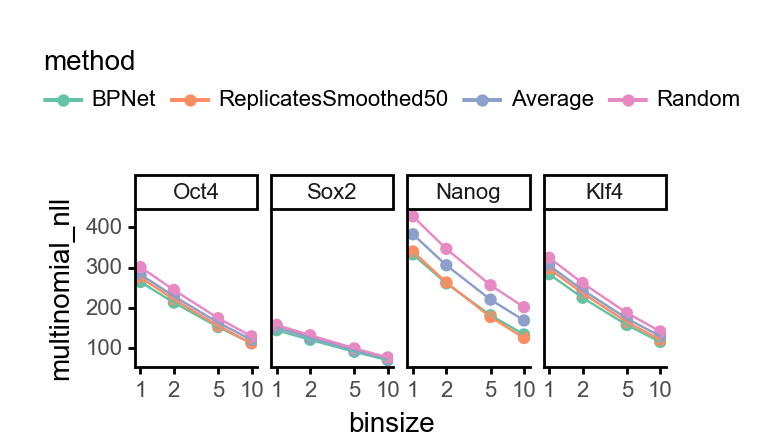

In [97]:
# TODO - plot other metrics than auprc
# - Jensen–Shannon_divergence
# - multinomial_nll
# - smoothed/Jensen–Shannon_divergence

for metric_name in ['Jensen–Shannon_divergence', 'multinomial_nll',
                    #'Jensen–Shannon_divergence_pc',
                    #'smoothed/Jensen–Shannon_divergence',
                    #'smoothed/Jensen–Shannon_divergence_pc',
                    #'smoothed/multinomial_nll'
                    ]:
    profile_methods = ["BPNet",
                       #"Replicates",
                       'ReplicatesSmoothed50',
                       # 'ReplicatesSmoothed3',
                       "Average", "Random"]
    df_auprc_tidy = df_auprc_tidy[df_auprc_tidy.binsize < 11]
    # metric = 'Jensen–Shannon_divergence'

    df_auprc_tidy2 = df_auprc_tidy[df_auprc_tidy.method.isin(profile_methods)]
    df_auprc_tidy2['method'] = pd.Categorical(df_auprc_tidy2['method'], categories=profile_methods)
    df_auprc_tidy2['task'] = pd.Categorical(df_auprc_tidy2['task'], categories=df_auprc_tidy['task'].unique())

    # TODO - merge in the constant
    
    plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
    fig = ggplot(aes(x='binsize', y=metric_name, color='method'),
                 data=df_auprc_tidy2.groupby(['binsize', 'task', 'method'])[metric_name].mean().reset_index()) + \
      scale_x_log10(breaks=binsizes) + \
      geom_point() + \
      geom_line() + \
      facet_grid(".~task") + \
      theme_classic(base_size=10, base_family='Arial') +  \
      theme(legend_position='top') + \
      scale_color_brewer('qual', 7)
    !mkdir -p {figures}/profile-metrics
    fig.save(f"{figures}/profile-metrics/{metric_name}.skip-unsmoothed-replicates.normal-scale.pdf")
    fig.save(f"{figures}/profile-metrics/{metric_name}.skip-unsmoothed-replicates.normal-scale.png", dpi=300)
    fig.draw()

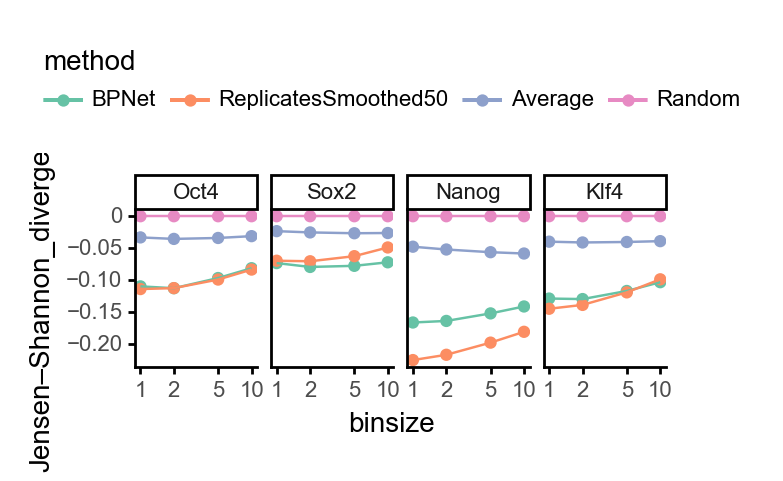

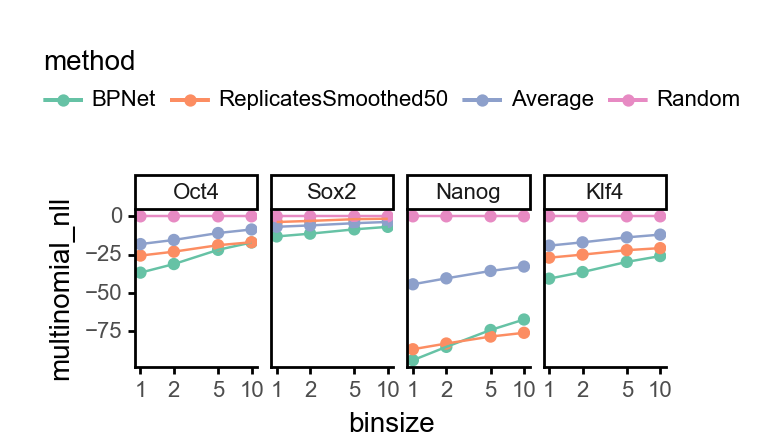

In [96]:
for metric_name in ['Jensen–Shannon_divergence', 'multinomial_nll',
                    #'Jensen–Shannon_divergence_pc',
                    #'smoothed/Jensen–Shannon_divergence',
                    #'smoothed/Jensen–Shannon_divergence_pc',
                    #'smoothed/multinomial_nll'
                    ]:
    profile_methods = ["BPNet",
                       #"Replicates",
                       'ReplicatesSmoothed50',
                       #'ReplicatesSmoothed3',
                       "Average", "Random"]
    df_auprc_tidy_normalized = df_auprc_tidy_normalized[df_auprc_tidy_normalized.binsize < 11]
    # metric = 'Jensen–Shannon_divergence'

    df_auprc_tidy2 = df_auprc_tidy_normalized[df_auprc_tidy_normalized.method.isin(profile_methods)]
    df_auprc_tidy2['method'] = pd.Categorical(df_auprc_tidy2['method'], categories=profile_methods)
    df_auprc_tidy2['task'] = pd.Categorical(df_auprc_tidy2['task'], categories=df_auprc_tidy['task'].unique())

    # TODO - merge in the constant
    
    plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
    fig = ggplot(aes(x='binsize', y=metric_name, color='method'),
                 data=df_auprc_tidy2.groupby(['binsize', 'task', 'method'])[metric_name].mean().reset_index()) + \
      scale_x_log10(breaks=binsizes) + \
      geom_point() + \
      geom_line() + \
      facet_grid(".~task") + \
      theme_classic(base_size=10, base_family='Arial') +  \
      theme(legend_position='top') + \
      scale_color_brewer('qual', 7)
    !mkdir -p {figures}/profile-metrics
    fig.save(f"{figures}/profile-metrics/{metric_name}.include-unsmoothed-replicates.pdf")
    fig.save(f"{figures}/profile-metrics/{metric_name}.include-unsmoothed-replicates.png", dpi=300)
    fig.draw()

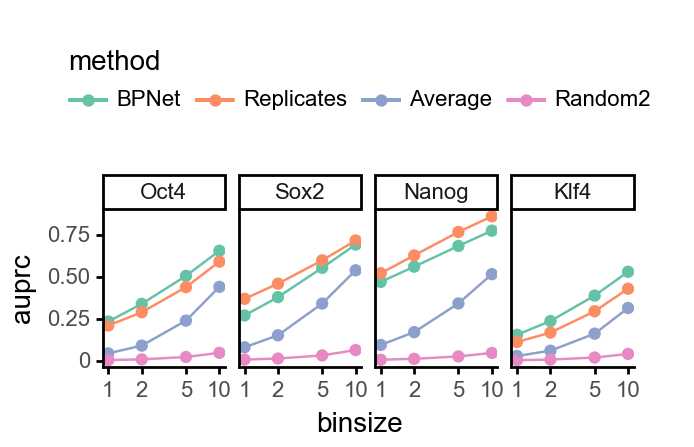

<ggplot: (-9223363311276450244)>

In [92]:
profile_methods = ["BPNet", "Replicates", "Average", "Random"]
df_auprc_tidy = df_auprc_tidy[df_auprc_tidy.binsize < 11]


profile_methods = ["BPNet",
                   "Replicates",
                   # 'ReplicatesSmoothed50',
                   #'ReplicatesSmoothed3',
                   "Average", 'Random2']
df_auprc_tidy2 = df_auprc_tidy[df_auprc_tidy.method.isin(profile_methods)]
# df_auprc_tidy2['method'].map(lambda x: {'Random2': 'Random', 'Random': 'Random3'}.get(x, x))
df_auprc_tidy2['method'] = pd.Categorical(df_auprc_tidy2['method'], categories=profile_methods)
df_auprc_tidy2['task'] = pd.Categorical(df_auprc_tidy2['task'], categories=df_auprc_tidy['task'].unique())


plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
fig = ggplot(aes(x='binsize', y='auprc', color='method'),
             data=df_auprc_tidy2.groupby(['binsize', 'task', 'method']).auprc.mean().reset_index()) + \
  scale_x_log10(breaks=binsizes) + \
  geom_point() + \
  geom_line() + \
  facet_grid(".~task") + \
  theme_classic(base_size=10, base_family='Arial') +  \
  theme(legend_position='top') + \
  scale_color_brewer('qual', 7)
!mkdir -p {figures}/profile-metrics
fig.save(f"{figures}/profile-metrics/auprc.v3.pdf")
fig.save(f"{figures}/profile-metrics/auprc.v3.png", dpi=300)
fig

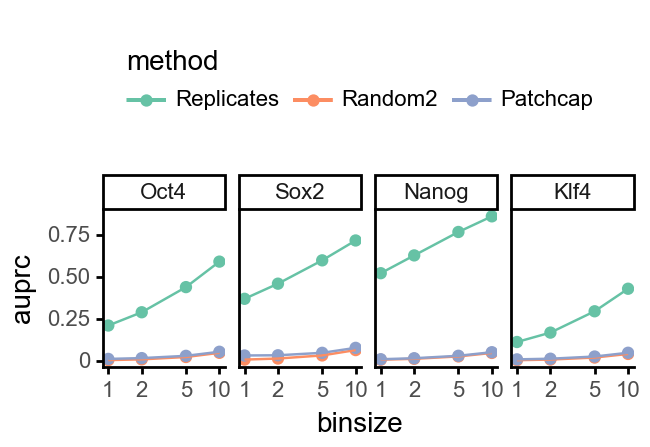

<ggplot: (-9223363311276698631)>

In [94]:
# Patchcap only
profile_methods = ["Replicates", "Random2", "Patchcap"]
df_auprc_tidy2 = df_auprc_tidy[df_auprc_tidy.method.isin(profile_methods) & (df_auprc_tidy.binsize < 11)]
df_auprc_tidy2['method'] = pd.Categorical(df_auprc_tidy2['method'], categories=profile_methods)
df_auprc_tidy2['task'] = pd.Categorical(df_auprc_tidy2['task'], categories=df_auprc_tidy['task'].unique())


plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
fig = ggplot(aes(x='binsize', y='auprc', color='method'),
             data=df_auprc_tidy2.groupby(['binsize', 'task', 'method']).auprc.mean().reset_index()) + \
  scale_x_log10(breaks=binsizes) + \
  geom_point() + \
  geom_line() + \
  facet_grid(".~task") + \
  theme_classic(base_size=10, base_family='Arial') +  \
  theme(legend_position='top') + \
  scale_color_brewer('qual', 7)
!mkdir -p {figures}/profile-metrics
fig.save(f"{figures}/profile-metrics/auprc-patchcap.v2.pdf")
fig.save(f"{figures}/profile-metrics/auprc-patchcap.v2.png", dpi=300)
fig

In [50]:
!mkdir -p {figures}/profile-metrics

### Plot total count performance

In [134]:
print(df_counts_tidy.groupby(['method', 'task']).pearsonr.mean().reset_index().to_string())

        method   task  pearsonr
0        BPNet   Klf4    0.6433
1        BPNet  Nanog    0.5948
2        BPNet   Oct4    0.6266
3        BPNet   Sox2    0.6115
4     Patchcap   Klf4    0.2212
5     Patchcap  Nanog    0.1963
6     Patchcap   Oct4    0.3187
7     Patchcap   Sox2    0.3908
8   Replicates   Klf4    0.9299
9   Replicates  Nanog    0.9801
10  Replicates   Oct4    0.9553
11  Replicates   Sox2    0.8741


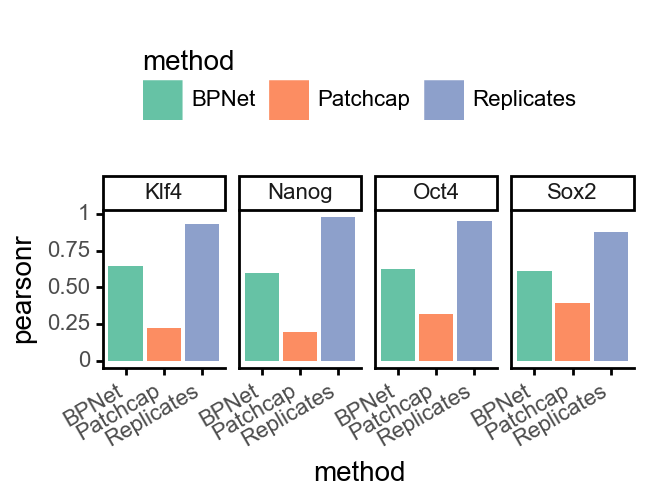

<ggplot: (8790660027554)>

In [132]:
fig = (ggplot(aes(x='method', fill='method', y = 'pearsonr'),
       data=df_counts_tidy.groupby(['method', 'task']).pearsonr.mean().reset_index())
 + geom_bar(stat='identity', position='dodge')
 + facet_grid('. ~ task')
 + theme_classic(base_size=10, base_family='Arial')
 + theme(legend_position='top')
 + scale_fill_brewer('qual', 7)
 + plt9_tilt_xlab(30)
)
fig.save(f"{figures}/profile-metrics/total-counts.pdf")
fig.save(f"{figures}/profile-metrics/total-counts.png", dpi=300)

fig

In [ ]:
df_counts_tidy['method'] = pd.Categorical(df_counts_tidy['method'], categories=["BPNet", "Replicates"])
df_counts_tidy['task'] = pd.Categorical(df_counts_tidy['task'], categories=df_counts_tidy['task'].unique())

### Scatterplot

In [78]:
def regression_eval(y_true, y_pred, alpha=0.5, markersize=2, task="", ax=None, same_lim=False, loglog=False):
    if ax is None:
        fig, ax = plt.subplots(1)
    from scipy.stats import pearsonr, spearmanr
    xmax = max([y_true.max(), y_pred.max()])
    xmin = min([y_true.min(), y_pred.min()])
    
    if loglog:
        pearson, pearson_pval = pearsonr(np.log10(y_true), np.log10(y_pred))
        spearman, spearman_pval = spearmanr(np.log10(y_true), np.log(y_pred))
    else:
        pearson, pearson_pval = pearsonr(y_true, y_pred)
        spearman, spearman_pval = spearmanr(y_true, y_pred)
    if loglog:
        plt_fn = ax.loglog
    else:
        plt_fn = ax.plot
        
    plt_fn(y_pred, y_true, ".", 
           markersize=markersize, 
           rasterized=True,
           alpha=alpha)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Observed")
    
    if same_lim:
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((xmin, xmax))
    
    ax.set_title(task)
    ax.text(0.95, .01, f"R={spearman:.2f}",
            verticalalignment='bottom',
            horizontalalignment='right',
            fontsize=8,
            transform=ax.transAxes)

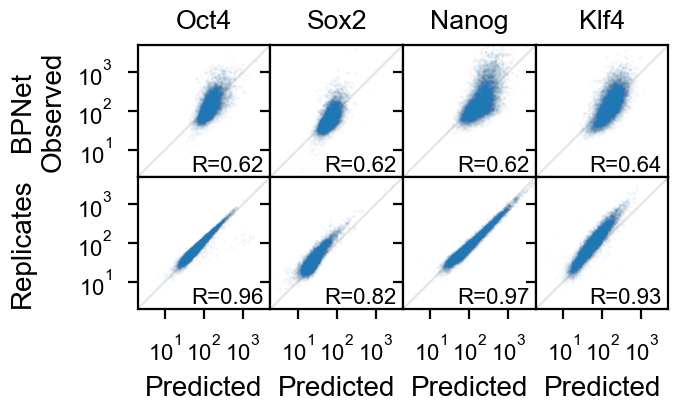

In [79]:
fig, axes = plt.subplots(2, len(tasks), figsize=get_figsize(frac=.5, aspect=2/len(tasks)),
                         sharex=True, sharey=True)
for i, task in enumerate(tasks):
    for j in range(2):
        ax = axes[j,i]
        
        if j == 0:
            # yp = np.exp(y_pred[f'{task}/counts'].mean(-1)*0.9)
            yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
            # yt = y_true[f'{task}/counts'].mean(-1) + 1
            yt = np.exp(y_true[f'counts/{task}'].mean(-1))
        else:
            yt = test[task].sum(axis=1).mean(-1) + 1
            yp = train[task].sum(axis=1).mean(-1) + 1
        xrange = [2, 5e3]
        ax.set_ylim(xrange)
        ax.set_xlim(xrange)

        ax.plot(xrange, xrange, c='grey', alpha=0.2)
        regression_eval(yt, 
                        yp, alpha=.01, task=task if j == 0 else '', ax=ax, loglog=True)
        
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=3))
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=3))
        if i > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("BPNet\nObserved" if j==0 else "Replicates\n")
fig.subplots_adjust(wspace=0, hspace=0)
plt.minorticks_off()
# Save the figure
fig.savefig(f"{figures}/scatter/all.pdf", dpi=300)
# fig.savefig(f"{figures}/scatter/all.png")